In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
'''
Load data
'''
# 94 行的Korea, South 手動更改為Korea South
data = np.loadtxt("covid_19.csv",dtype=np.str,delimiter=',')
data = np.delete(data, [0,1,2], 0)
data = np.delete(data, [1,2], 1)
countries = data[:,0]
data = np.delete(data, [0], 1)
data

array([['0', '0', '0', ..., '521', '555', '607'],
       ['0', '0', '0', ..., '416', '433', '446'],
       ['0', '0', '0', ..., '1761', '1825', '1914'],
       ...,
       ['0', '0', '0', ..., '1', '1', '1'],
       ['0', '0', '0', ..., '40', '40', '43'],
       ['0', '0', '0', ..., '13', '14', '14']], dtype='<U32')

In [5]:
data

array([['0', '0', '0', ..., '521', '555', '607'],
       ['0', '0', '0', ..., '416', '433', '446'],
       ['0', '0', '0', ..., '1761', '1825', '1914'],
       ...,
       ['0', '0', '0', ..., '1', '1', '1'],
       ['0', '0', '0', ..., '40', '40', '43'],
       ['0', '0', '0', ..., '13', '14', '14']], dtype='<U32')

In [6]:
print(data.shape) #185 countries,  82days
data

(185, 82)


array([['0', '0', '0', ..., '521', '555', '607'],
       ['0', '0', '0', ..., '416', '433', '446'],
       ['0', '0', '0', ..., '1761', '1825', '1914'],
       ...,
       ['0', '0', '0', ..., '1', '1', '1'],
       ['0', '0', '0', ..., '40', '40', '43'],
       ['0', '0', '0', ..., '13', '14', '14']], dtype='<U32')

In [8]:
data[0]

array(['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '4', '4', '5', '7', '7', '7',
       '11', '16', '21', '22', '22', '22', '24', '24', '40', '40', '74',
       '84', '94', '110', '110', '120', '170', '174', '237', '273', '281',
       '299', '349', '367', '423', '444', '484', '521', '555', '607'],
      dtype='<U32')

In [13]:
test = data.astype(int)
# 計算差值 共有81個差值
for i in range(data.shape[0]):
    for j in range(1,data.shape[1]):
        test[i][j] = data[i][j].astype(int) - data[i][j-1].astype(int)
test[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  1,  2,  0,
        0,  4,  5,  5,  1,  0,  0,  2,  0, 16,  0, 34, 10, 10, 16,  0, 10,
       50,  4, 63, 36,  8, 18, 50, 18, 56, 21, 40, 37, 34, 52])

In [18]:
test = test[:,:81]
print(test.shape)

(185, 81)


In [19]:
'''
Correlation coefficient matrix
'''
corrcoef_matrix = np.zeros((len(countries),len(countries)))

for i in range(len(countries)):
    for j in range(len(countries)):
        c1 = test[i].astype(int)
        c2 = test[j].astype(int)
        
        corrcoef_matrix[j][i] = np.corrcoef(c1,c2)[0][1]

In [27]:
# corrcoef_matrix[0][0]
corrcoef_matrix[:10,:10].shape

(10, 10)

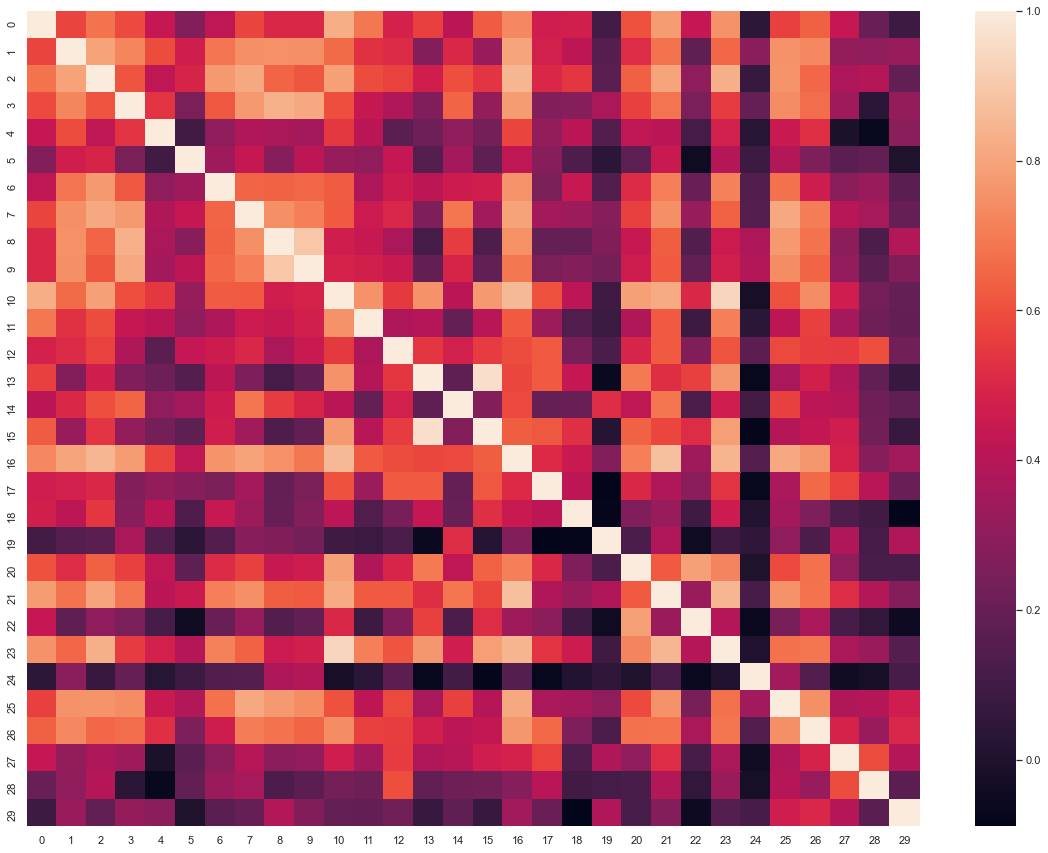

In [31]:
sns.set()
plt.subplots(figsize=(20,15))
sns.heatmap(corrcoef_matrix[:30,:30])

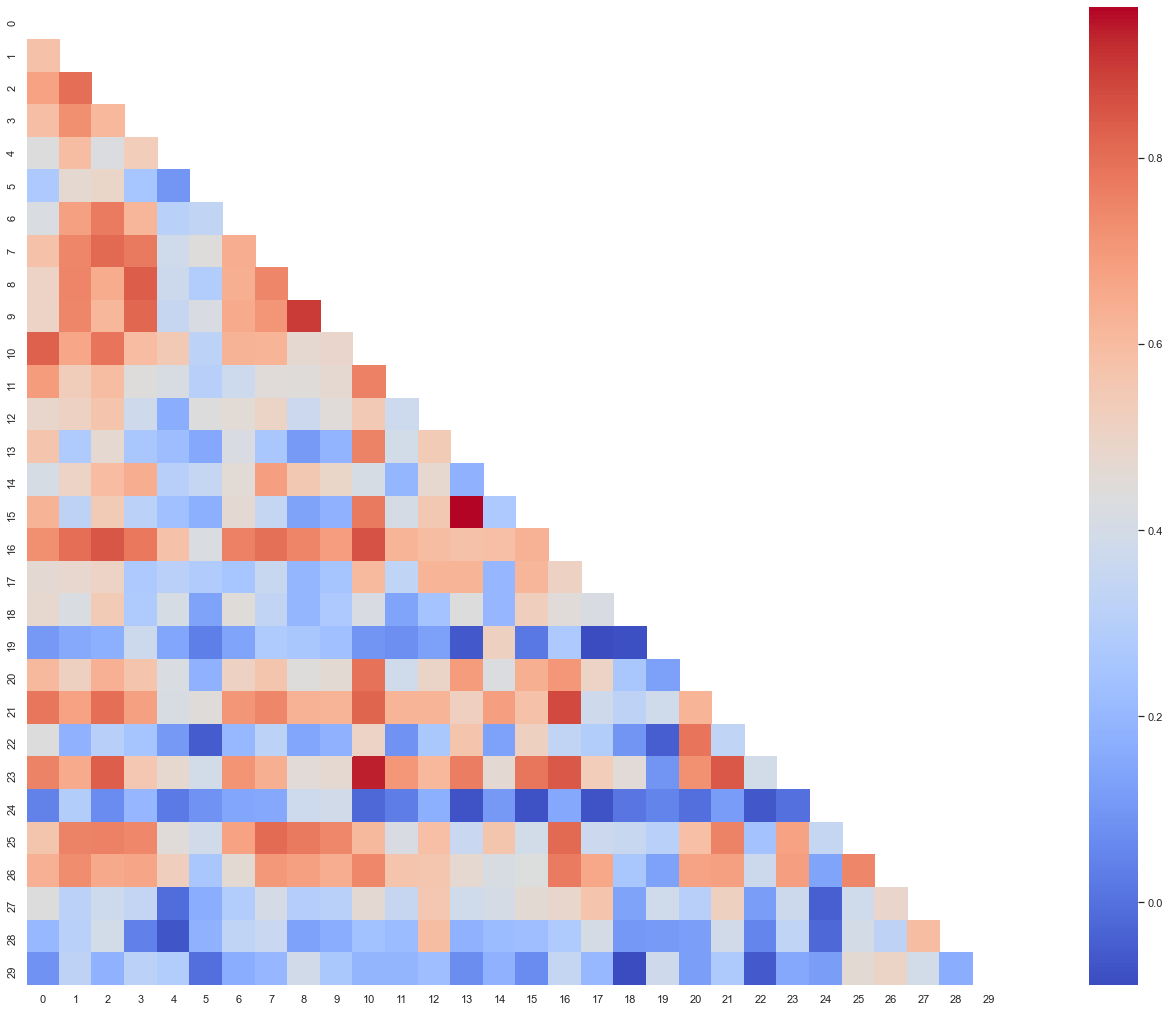

In [33]:
mask = np.zeros_like(corrcoef_matrix[:30,:30])
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(30,18))
    ax = sns.heatmap(corrcoef_matrix[:30,:30], mask=mask, square=True, cmap="coolwarm")

In [64]:
threshold = .85
# 0.70 -> 148
# 0.75 -> 129
# 0.80 -> 107
# 0.85 -> 87
# 0.90 -> 58
length = len(corrcoef_matrix)
country_list = []
for i in range(length):
    for j in range(length):
        if abs(corrcoef_matrix[i][j]) > threshold and i != j:
            country_list.append(i)
            country_list.append(j)
# len(country_list)
C = np.unique(country_list)
len(C)

87

In [67]:
# abs(corrcoef_matrix[28][4])

In [66]:
# threshold = .85
# # np.count_nonzero((corrcoef_matrix > threshold)) #總共185*185=34225
# high_corrcoef_matrix = np.where(corrcoef_matrix > threshold)
# high_corrcoef_matrix

In [65]:
# L = 5 # interval
# C = []
# for i in range(len(high_corrcoef_matrix[0])):
#     if high_corrcoef_matrix[0][i] - high_corrcoef_matrix[1][i] != 0:
#         C.append(high_corrcoef_matrix[0][i])
#         C.append(high_corrcoef_matrix[1][i])
# np.unique(C)

In [90]:
'''
Generate sequence data
'''
L = 5 # interval
C # 符合threshold的國家 共87個
print("data shape:", data[C].shape)
C_data = data[C]
seqData = []
seqLabel = []
for i in range(C_data.shape[0]): # 87國家
    for j in range(C_data.shape[1]-(L)): # 82-5=77 
        x = C_data[i] # i th country
        seqData.append(x[j:j+L].astype(int)) # 會少了最後一個 因為沒有index=82
        seqLabel.append(1 if x[j+L]>x[j+L-1] else 0)
len(seqData), len(seqLabel) #14245

data shape: (87, 82)


(6699, 6699)

In [91]:
seqData[0]

array([0, 0, 0, 0, 0])

In [81]:
# '''
# Generate sequence data
# '''
# seqData = []
# seqLabel = []
# for i in range(data.shape[0]): # 185
#     for j in range(data.shape[1]-(L)): # 82-5=77 
#         x = data[i] # i th country
#         seqData.append(x[j:j+L]) # 會少了最後一個 因為沒有index=82
#         seqLabel.append(1 if x[j+L]>x[j+L-1] else 0)
# len(seqData), len(seqLabel) #14245

In [92]:
'''
PyTorch
'''
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
torch.manual_seed(1)

In [94]:
print("Countries:", 6699/77)
print(seqData[76]) #0~76為同一個國家
temp = np.array(seqData).reshape((87,77,5)) # 87 個國家，一個seq五天，每個國家有77個seq
temp[0].shape

Countries: 87.0
[383 400 409 416 433]


(77, 5)

In [101]:
x = torch.Tensor(seqData)
y = torch.Tensor(seqLabel)

print("X:",x.shape," Y:",y.shape)
x, y # seqData, seqLabel

X: torch.Size([6699, 5])  Y: torch.Size([6699])


(tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.],
         ...,
         [0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 1., 1.]]),
 tensor([0., 0., 0.,  ..., 1., 0., 0.]))

In [108]:
input_size = 1
seq_length = 5
hidden_size = 2
number_of_layers = 1
batchsize = 4


In [109]:
import torch.utils.data as Data
torch_dataset = Data.TensorDataset(x,y) # 轉成torch能夠識別的dataset
# 把dataset放到dataloader裡
loader = Data.DataLoader(
    dataset=torch_dataset,      # torch TensorDataset format
    batch_size=batchsize,      # mini batch size
    shuffle=True,               # 要不要打乱数据 (打乱比较好)
    num_workers=2,              # 多线程来读数据
)

In [113]:
for epoch in range(3):   # 训练所有!整套!数据 3 次
    for step, (batch_x, batch_y) in enumerate(loader):  
        # 每一步 loader 释放一小批数据用来学习
        # 假设这里就是你训练的地方...

        print('Epoch: ', epoch, '| Step: ', step, '| batch x: ',
              batch_x.numpy(), '| batch y: ', batch_y.numpy())

]
Epoch:  2 | Step:  1573 | batch x:  [[ 0.  0.  0.  0.  0.]
 [15. 15. 25. 27. 30.]
 [ 8.  8.  8. 10. 12.]
 [ 2.  6.  6. 18. 18.]] | batch y:  [0. 1. 0. 1.]
Epoch:  2 | Step:  1574 | batch x:  [[245. 331. 448. 448. 785.]
 [  3.   6.   6.  14.  26.]
 [  0.   0.   0.   0.   0.]
 [380. 435. 464. 531. 584.]] | batch y:  [0. 0. 0. 1.]
Epoch:  2 | Step:  1575 | batch x:  [[   0.    0.    0.    0.    0.]
 [   0.    0.    0.    0.    0.]
 [1746. 2281. 2561. 2954. 4342.]
 [   0.    0.    0.    0.    0.]] | batch y:  [0. 0. 1. 0.]
Epoch:  2 | Step:  1576 | batch x:  [[0.000e+00 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [1.440e+02 1.490e+02 1.720e+02 1.810e+02 2.050e+02]
 [1.000e+00 1.000e+00 1.000e+00 1.000e+00 1.000e+00]
 [8.020e+02 1.144e+03 1.145e+03 1.551e+03 1.960e+03]] | batch y:  [0. 1. 0. 1.]
Epoch:  2 | Step:  1577 | batch x:  [[0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1.]
 [9. 9. 9. 9. 9.]
 [0. 0. 0. 1. 3.]] | batch y:  [0. 1. 0. 1.]
Epoch:  2 | Step:  1578 | batch x:  [[   0.    0.    0.    0.  

In [103]:
'''參考'''

'參考'

In [ ]:
# Number of features used as input. (Number of columns)
INPUT_SIZE = 1
# Number of previous time stamps taken into account.
SEQ_LENGTH = 5
# Number of features in last hidden state ie. number of output time-
# steps to predict.See image below for more clarity.
HIDDEN_SIZE = 2
# Number of stacked rnn layers.
NUM_LAYERS = 1
# We have total of 20 rows in our input. 
# We divide the input into 4 batches where each batch has only 1
# row. Each row corresponds to a sequence of length 5. 
BATCH_SIZE = 4

In [ ]:
# Initialize the RNN.
rnn = nn.RNN(input_size=INPUT_SIZE, hidden_size=HIDDEN_SIZE, num_layers = 1, batch_first=True)
# input size : (batch, seq_len, input_size)
inputs = data.view(BATCH_SIZE, SEQ_LENGTH, INPUT_SIZE)
# out shape = (batch, seq_len, num_directions * hidden_size)
# h_n shape  = (num_layers * num_directions, batch, hidden_size)
out, h_n = rnn(inputs)

In [ ]:
print('Input: ', inputs.shape, '\n', inputs)
print('\nOutput: ', out.shape, '\n', out)
print('\nHidden: ', h_n.shape, '\n', h_n)